In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm


/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [3]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [4]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [5]:
# make aggregate data matrix - USED --don't need to run again
#nVox = 3757
#nTRs = 475
#nSub = 38
#aggregate_masked_data = np.zeros((nVox,nTRs,nSub))
#for s in np.arange(nsub):
#    subjName=allnames[s]
#    subjData=fmriprep_dir + '/' + subjName + '/' + 'func' + '/' + subjName + '_task-prettymouth_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
#    masked_data = apply_mask(subjData, DMNmask)
#    aggregate_masked_data[:,:,s] = masked_data.T

#np.save('aggregate_data.npy', aggregate_masked_data)

In [5]:
images_SRM_removed = np.load('aggregated_SRM_removed.npy')
images_original = np.load('aggregate_data.npy')
# this is in shape voxels x TRs x subjects

In [6]:
vox_num, nTR, num_subs = images_SRM_removed.shape  # Pull out the shape data

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  38
Voxels per participant  3757
TRs per participant  475


In [7]:
# make processed data once for training/testing
prepared_data = []
for sub in range(num_subs):
    prepared_data.append(images_SRM_removed[:,:,sub])
for sub in range(num_subs):
    #prepared_data[sub] = stats.zscore(prepared_data[sub],axis=1,ddof=1)
    prepared_data[sub] = np.nan_to_num(prepared_data[sub])
    
# this makes prepared data in subjects x voxels x TRs

In [8]:
vox_num, nTR, num_subs = images_original.shape  # Pull out the shape data

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

train_data = []
for sub in range(num_subs):
    train_data.append(images_original[:, :, sub])  #

for sub in range(num_subs):
    train_data[sub] = stats.zscore(train_data[sub],axis=1,ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])

features = 10
n_iter = 20
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
print('Fitting SRM, may take a few minutes')
if features > 0:
    srm.fit(train_data)
    S = srm.s_
print('SRM has been fit')
# Fit the SRM data
# the output matrix srm.s_ will be in features x time points space
# then project this output matrix onto each subject's voxel space
nVox = 3757
nTRs = 475
nSub = 38
aggregated_SRM_removed = np.zeros((nVox,nTRs,nSub))
for s in np.arange(nSub):
    if features > 0:
        w = srm.w_[s]
        signal_srm = w.dot(S) # reconstructed signal
    else:
        signal_srm = 0
    signal_original = train_data[s]
    subtracted_signal = signal_original - signal_srm
    aggregated_SRM_removed[:,:,s] = subtracted_signal

Participants  38
Voxels per participant  3757
TRs per participant  475


/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/scipy/stats/stats.py:2246: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


Fitting SRM, may take a few minutes
SRM has been fit


In [9]:
train_data

[array([[-1.63426536, -2.23910377, -2.02766446, ...,  0.80846859,
          1.14494172,  0.98127956],
        [-1.5287858 , -1.18054402, -1.3433738 , ...,  0.25877611,
         -0.01696482,  0.44894227],
        [-1.30260013, -0.85417784, -1.04749767, ...,  0.0964774 ,
          0.94150428,  1.11290124],
        ...,
        [ 1.90582674,  0.69850455, -0.31895648, ..., -0.31652237,
          0.71310926, -0.15830474],
        [ 0.24211505,  0.18381382, -0.12682244, ..., -1.23363492,
         -1.63809973, -1.10063523],
        [ 0.42801155,  0.85025306,  0.20262587, ..., -3.27611163,
         -2.6703282 , -1.72313778]]),
 array([[-2.69929793, -0.20349143, -0.60204281, ...,  0.0127956 ,
          1.66532571,  1.58755958],
        [-0.49425431, -1.26365416, -0.61226043, ..., -0.62642116,
          0.50171727,  0.303467  ],
        [ 1.42938406, -0.22265291, -0.19784755, ...,  0.38259787,
         -0.93704727, -0.32187435],
        ...,
        [ 0.16586902, -0.19597375, -0.14378489, ..., -

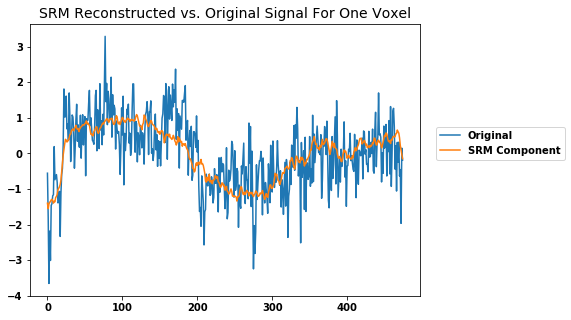

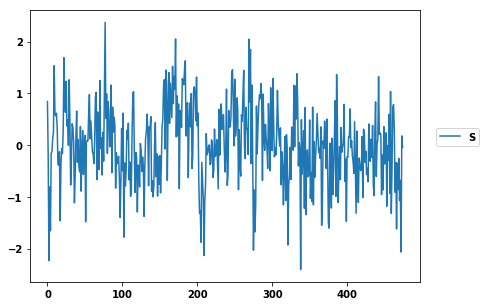

In [10]:
s=5
original = train_data[s]
srm_removed = images_SRM_removed[:,:,s]
srm_component = srm.w_[s].dot(srm.s_)
plt.figure(figsize=(7,5))
plt.title('SRM Reconstructed vs. Original Signal For One Voxel', fontsize=14)
plt.plot(original[1,:])
plt.plot(srm_component[1,:])
plt.legend(('Original', 'SRM Component'), loc=(1.04,0.5))
plt.figure(figsize=(7,5))
plt.plot(srm_removed[1,:])
plt.legend(('SRM removed'), loc=(1.04,0.5))

In [11]:
np.shape(train_data)

(38, 3757, 475)

In [12]:
n_per_category = 19
indTrain = np.arange(n_per_category)
features = 100
n_iter = 20
accuracy = np.zeros(nfolds)

for f in np.arange(1):
    trainingSubjectsInd = np.concatenate([indTrain[:f], indTrain[f+1:]]) # take all indices but fold
    s1 = np.arange(n_per_category)
    trainingInd = np.array([np.int(s1[j]) for j in trainingSubjectsInd])
    print(trainingInd)
    srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
    # remake list object for this iteration
    training_data = []
    for sub in range(n_per_category-1):
        training_data.append(prepared_data[trainingInd[sub]])
    print('Fitting SRM, may take a few minutes')
    srm.fit(training_data)
    print('SRM has been fit')
    # now we want to bring all subjects back into residual space but with ONLY the shared component
    # training data for the classifier will be a vector nsub x nvoxels*TR
    training_data_classifier_SRM = np.zeros((num_subs-2,vox_num*nTR))
    S1 = srm.s_
    for s_ind1 in np.arange(n_per_category-1):
        w = srm.w_[s_ind1]
        signal_srm = w.dot(S1) # reconstructed shared signal
        signal_transposed = signal_srm.T
        training_data_classifier_SRM[s_ind1,:] = signal_transposed.flatten()

    # repeat with other condition
    s2 = np.arange(19) + 19
    trainingInd = np.array([np.int(s2[j]) for j in trainingSubjectsInd])
    print(trainingInd)
    srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
    # remake list object for this iteration
    training_data = []
    for sub in range(n_per_category-1):
        training_data.append(prepared_data[trainingInd[sub]])
    print('Fitting SRM, may take a few minutes')
    srm.fit(training_data)
    print('SRM has been fit')
    S2 = srm.s_
    for s_ind2 in np.arange(n_per_category-1):
        w = srm.w_[s_ind2]
        signal_srm = w.dot(S2) # reconstructed shared signal
        signal_transposed = signal_srm.T
        training_data_classifier_SRM[s_ind2+s_ind1,:] = signal_transposed.flatten()

    trainingLabels = [paranoidLabel[j] for j in trainingSubjectsInd]+[cheatingLabel[j] for j in trainingSubjectsInd]
    testingLabels = np.array([paranoidLabel[f],cheatingLabel[f]])
    testingInd = np.array([f,f+19])
    testing_data_classifier = np.zeros((2,vox_num*nTR))
    for sub in np.arange(len(testingInd)):
        subjdata = prepared_data[testingInd[sub]].T
        testing_data_classifier[sub,:] = subjdata.flatten()
    clf = LinearSVC()
    clf.fit(training_data_classifier_SRM,trainingLabels)
    accuracy[f] = clf.score(testing_data_classifier,testingLabels)
    print('fold %i:' % f)
    print('accuracy is %2.2f' % accuracy[f])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Fitting SRM, may take a few minutes
SRM has been fit
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Fitting SRM, may take a few minutes


KeyboardInterrupt: 

In [15]:
training_data_classifier_SRM[-1]

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
np.shape(training_data_classifier_SRM)

(36, 1784575)

In [57]:
#35 == last index is just 0
s_ind1+s_ind2

34

In [60]:
np.arange(18) + 18

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35])

In [59]:
s_ind2

17

In [87]:
# repeat with other condition
s2 = np.arange(19) + 19
trainingInd = np.array([np.int(s2[j]) for j in trainingSubjectsInd])
print(trainingInd)
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
# remake list object for this iteration
training_data = []
for sub in range(n_per_category-1):
    training_data.append(prepared_data[trainingInd[sub]])
print('Fitting SRM, may take a few minutes')
srm.fit(training_data)
print('SRM has been fit')
S2 = srm.s_
for s_ind2 in np.arange(n_per_category-1):
    w = srm.w_[s_ind2]
    signal_srm = w.dot(S2) # reconstructed shared signal
    signal_transposed = signal_srm.T
    training_data_classifier_SRM[s_ind2+s_ind1,:] = signal_transposed.flatten()

[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Fitting SRM, may take a few minutes
SRM has been fit


In [ ]:
mean_acc = np.mean(accuracy)
print('mean accuracy is %2.2f +/- %2.2f' % (mean_acc,scipy.stats.sem(accuracy)))
# first try: 73.6 % accuracy

In [90]:
trainingLabels = [paranoidLabel[j] for j in trainingSubjectsInd]+[cheatingLabel[j] for j in trainingSubjectsInd]
testingLabels = np.array([paranoidLabel[f],cheatingLabel[f]])
testingInd = np.array([f,f+19])
testing_data_classifier = np.zeros((2,vox_num*nTR))
for sub in np.arange(len(testingInd)):
    subjdata = prepared_data[testingInd[sub]].T
    testing_data_classifier[sub,:] = subjdata.flatten()
clf = LinearSVC()
clf.fit(training_data_classifier_SRM,trainingLabels)
accuracy[f] = clf.score(testing_data_classifier,testingLabels)
print(f)
print(accuracy[f])

0
0.5


In [94]:
print('fold %i:' % f)
print('accuracy is %2.2f' % accuracy[f])

fold 0:
accuracy is 0.50


In [93]:
accuracy[f]

0.5